### 1.- Set up the enviroment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [66]:
#import tensorflow as tf
#print(tf.__version__)

#### 1.1 tensorflow 2.2.0

In [69]:
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout
from tensorflow.keras.models import Sequential

#### 1.2 sklearn 

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

### Time series: examples

### Series 1.

In [2]:
x1 = 2*np.pi* np.linspace( 0, 100, 100)
e1 = 2.5*np.random.normal( 0, 1, 100) #some noise

r1 = [1.62866234, 6.45871695, 1.50770171, 17.6739374, 1.00205858, 11.05110927, 12.12246389, 5.1125396 ]

y1 = r1[0] + r1[1]*np.cos(r1[2]*x1) + r1[3]*np.sin(x1) + np.cos(x1) + r1[5]*np.sin(x1) - e1

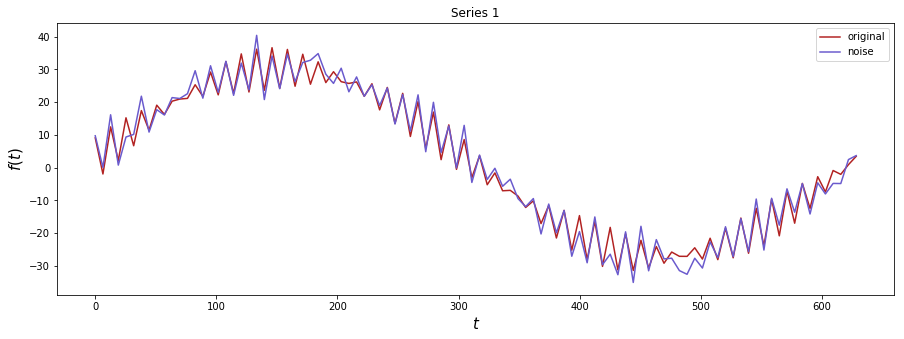

In [3]:
plt.figure(figsize = (15,5))
plt.plot( x1, y1 + e1, color = 'firebrick', label = 'original')

plt.plot( x1, y1, color = 'slateblue' ,label = 'noise')
#plt.plot( x1, y1,'b.' ,label = 'noise')

plt.legend(loc = 'best')
plt.title('Series 1')
plt.xlabel('$t$', fontsize = 15)
plt.ylabel('$f(t)$', fontsize = 15)
plt.show()

### Series 2.

In [4]:
x2 = 2*np.pi* np.linspace( 0, 1000, 200)
e2 = np.random.normal( 0, 1.2, 200)

r2 = [0.18032283, 1.19359851, 0.78283639, 0.00709187, 0.46570131, 0.85325773, 0.10872303]

y2 = r2[0] + r2[1]*np.cos(r2[2]*x2) + r2[3]*np.sin(x2) + np.cos(x2) + r2[5]*np.sin(x2) + e2

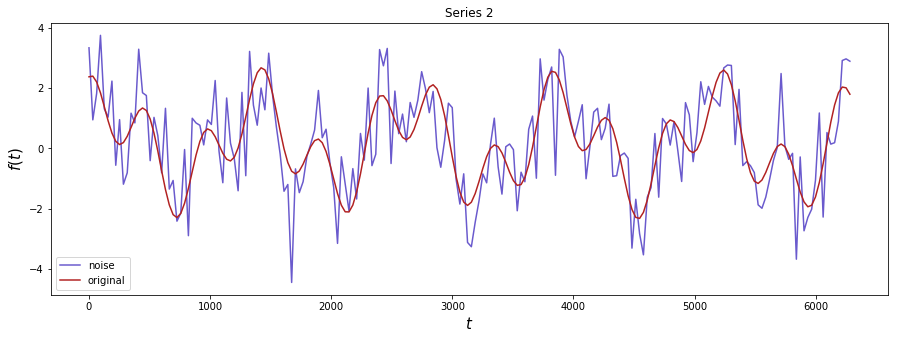

In [5]:
plt.figure(figsize = (15,5))
plt.plot( x2, y2, color = 'slateblue', label = 'noise')
plt.plot( x2, y2 - e2, color = 'firebrick', label = 'original')
plt.legend(loc = 'best')
plt.title('Series 2')
plt.xlabel('$t$', fontsize = 15)
plt.ylabel('$f(t)$', fontsize = 15)
plt.show()

### Series 3.

In [6]:
x3 = (np.pi)*np.linspace( 0, 50, 50)
y3 = 25*np.sin(4.05*x3)*np.exp(-0.03*x3) 

In [7]:
y3 = np.hstack((y3,y3,y3,y3,y3))

In [8]:
e3 = np.random.normal(0,1,len(y3))
y3 = y3 + e3

In [14]:
y3.shape

(250,)

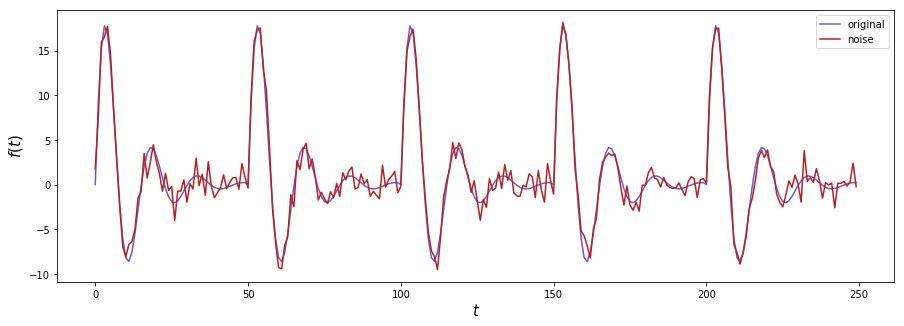

In [9]:
plt.figure(figsize = (15,5))
plt.plot( y3 - e3, color = 'slateblue', label = 'original')
plt.plot( y3, color = 'firebrick', label = 'noise')
plt.legend(loc = 'best')
plt.xlabel('$t$', fontsize = 15)
plt.ylabel('$f(t)$', fontsize = 15)
plt.show()

In [64]:
def get_window_data(data, window):
    # Get window data and scale
    scaler = MinMaxScaler(feature_range=(0, 1))
    #data = scaler.fit_transform(data.reshape(-1, 1))
    data = data.reshape(-1, 1)

    
    X = []
    y = []

    for i in range(len(data) - window - 1):
        X.append(data[i : i + window])
        y.append(data[i + window + 1])

    X = np.asarray(X)
    y = np.asarray(y)
    return X, y, scaler



def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X[:test_index,:]
    y_train = y[:test_index]
    
    X_test  = X[test_index:,:]
    y_test  = y[test_index:]
    
    return X_train, X_test, y_train, y_test

In [30]:
window_size = 50
X, y, scaler = get_window_data(y3, window_size)

In [40]:
X_train1, X_test1, y_train1, y_test1 = timeseries_train_test_split(X, y, test_size = 0.25)

In [42]:
X_train1.shape, X_test1.shape, y_train1.shape, y_test1.shape


((149, 50, 1), (50, 50, 1), (149, 1), (50, 1))

In [81]:
model1 = Sequential( [ LSTM( 50, input_shape=( window_size, 1)),
                      Dropout(0.2),
                      Dense(1),
                      Activation("linear") 
                     ] )

In [82]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [83]:

model1.compile(loss="mse", optimizer="adam")

In [85]:
history = model1.fit(
    X_train1,
    y_train1,
    epochs=20,
    batch_size=10,
    validation_data=(X_test1, y_test1),
    verbose=2,
    shuffle=False,
)

Epoch 1/20
15/15 - 1s - loss: 31.3327 - val_loss: 29.6304
Epoch 2/20
15/15 - 0s - loss: 29.8486 - val_loss: 28.0240
Epoch 3/20
15/15 - 0s - loss: 28.1068 - val_loss: 26.2244
Epoch 4/20
15/15 - 0s - loss: 26.2698 - val_loss: 23.8853
Epoch 5/20
15/15 - 0s - loss: 24.4137 - val_loss: 21.0117
Epoch 6/20
15/15 - 0s - loss: 21.2632 - val_loss: 18.3151
Epoch 7/20
15/15 - 0s - loss: 18.8638 - val_loss: 16.6953
Epoch 8/20
15/15 - 0s - loss: 16.8014 - val_loss: 14.5960
Epoch 9/20
15/15 - 0s - loss: 15.8933 - val_loss: 13.7628
Epoch 10/20
15/15 - 0s - loss: 14.7118 - val_loss: 12.2316
Epoch 11/20
15/15 - 0s - loss: 13.9323 - val_loss: 11.3338
Epoch 12/20
15/15 - 0s - loss: 13.0883 - val_loss: 10.6913
Epoch 13/20
15/15 - 0s - loss: 12.4761 - val_loss: 10.4378
Epoch 14/20
15/15 - 0s - loss: 11.9811 - val_loss: 10.7925
Epoch 15/20
15/15 - 0s - loss: 11.3828 - val_loss: 9.1009
Epoch 16/20
15/15 - 0s - loss: 11.0366 - val_loss: 8.5807
Epoch 17/20
15/15 - 0s - loss: 10.4670 - val_loss: 8.3117
Epoch 18/

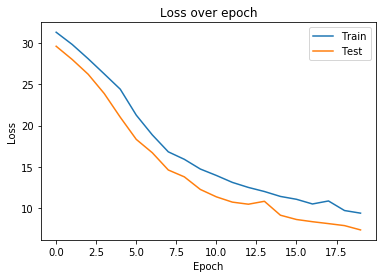

In [87]:
plt.figure(figsize=(6, 4))
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Test")
plt.title("Loss over epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc = 'best')
plt.show()

In [91]:
pred1 = model1.predict(X_test1)
#pred_inverse1 = scaler.inverse_transform(pred.reshape(-1, 1))
#y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate mean_squared_error. Previosly we did MinMax scale, so apply inverse_transform to recover values
rmse = np.sqrt(mean_squared_error(y_test1, pred1))
print("Test RMSE: %.3f" % rmse)


Test RMSE: 2.705


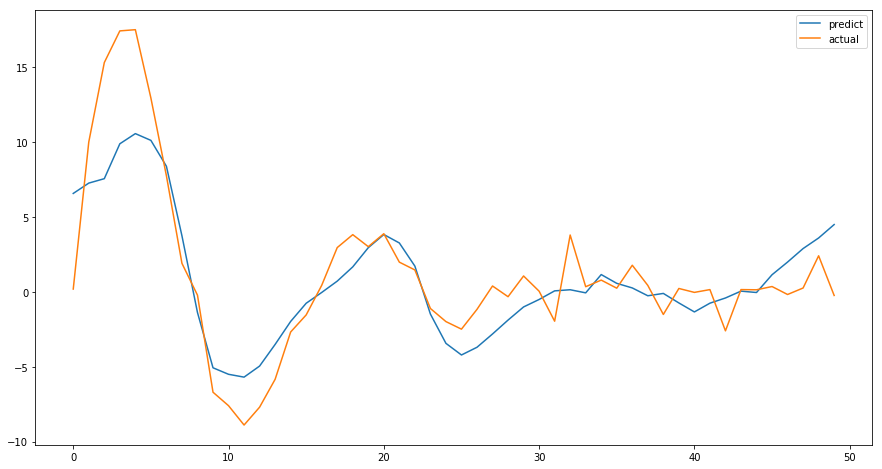

In [92]:
plt.figure(figsize=(15, 8))
plt.plot(pred1, label="predict")
plt.plot(y_test1, label="actual")
plt.legend()
plt.show()